# Preprocessing

In [30]:
import os
import tensorflow as tf

# Define paths to training and testing datasets
path = os.getcwd()
TRAIN_PATH = os.path.join(path, 'archive/Train')
TEST_PATH = os.path.join(path, 'archive/Test-A')

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 224
BATCH_SIZE = 32

data_gen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)


train_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='training',batch_size = BATCH_SIZE,shuffle = True,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='validation',batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = TEST_PATH,batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


# LSTM

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape

# Get number of classes
num_classes = len(train_gen.class_indices)

# Pure LSTM model - reshape image to sequence
model = Sequential([
    Reshape((IMAGE_SIZE, IMAGE_SIZE * 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 224, 672)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 224, 256)       │       951,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 224, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 224, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 224, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,789 (4.60 MB)

 Trainable params: 1,206,789 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10
)

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 170s 658ms/step - accuracy: 0.6098 - loss: 1.1108 - val_accuracy: 0.6129 - val_loss: 1.0853
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 160s 628ms/step - accuracy: 0.6123 - loss: 1.0921 - val_accuracy: 0.6129 - val_loss: 1.0745
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 168s 657ms/step - accuracy: 0.6123 - loss: 1.0892 - val_accuracy: 0.6129 - val_loss: 1.0783
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 158s 620ms/step - accuracy: 0.6123 - loss: 1.0876 - val_accuracy: 0.6129 - val_loss: 1.0739
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 164s 644ms/step - accuracy: 0.6123 - loss: 1.0894 - val_accuracy: 0.6129 - val_loss: 1.0737
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 167s 653ms/step - accuracy: 0.6123 - loss: 1.0863 - val_accuracy: 0.6129 - val_loss: 1.0732
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 186s 728ms/step - accuracy: 0.6123 - loss: 1.0836 - val_accuracy: 0.6129 - val_loss: 1.0731
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 165s 645ms/step - accuracy: 0.6123 -

In [34]:
# Evaluate on test data
print("\n" + "="*50)
print("EVALUATING ON TEST SET...")
print("="*50)

test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*50)

# Compare all three sets
print("\n" + "="*50)
print("COMPARISON: TRAIN vs VALIDATION vs TEST")
print("="*50)
print(f"Training Accuracy:   {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f} ({history.history['val_accuracy'][-1]*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*50)


EVALUATING ON TEST SET...


/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - accuracy: 0.6130 - loss: 1.0725

TEST SET RESULTS
Test Accuracy: 0.6130 (61.30%)
Test Loss: 1.0725

COMPARISON: TRAIN vs VALIDATION vs TEST
Training Accuracy:   0.6123 (61.23%)
Validation Accuracy: 0.6129 (61.29%)
Test Accuracy:       0.6130 (61.30%)


In [35]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*50)

136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 201ms/step - accuracy: 0.6130 - loss: 1.0725

TEST SET EVALUATION
Test Accuracy: 0.6130 (61.30%)
Test Loss: 1.0725


In [36]:
def plot_curves(history, model_name):
    def plot_loss_curves(history, plot):
        plot.plot(history.history['loss'], label='Train Loss')
        plot.plot(history.history['val_loss'], label='Validation Loss')
        plot.set_title(f'{model_name}: Training & Validation Loss')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Mean Squared Error (Loss)')
        plot.legend()
        plot.grid(True)

    def plot_accuracy_curves(history, plot):
        plot.plot(history.history['accuracy'], label='Train Accuracy')
        plot.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plot.set_title(f'{model_name}: Training & Validation Accuracy')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Accuracy')
        plot.legend()
        plot.grid(True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plot_loss_curves(history, ax1)
    plot_accuracy_curves(history, ax2)
    plt.show()

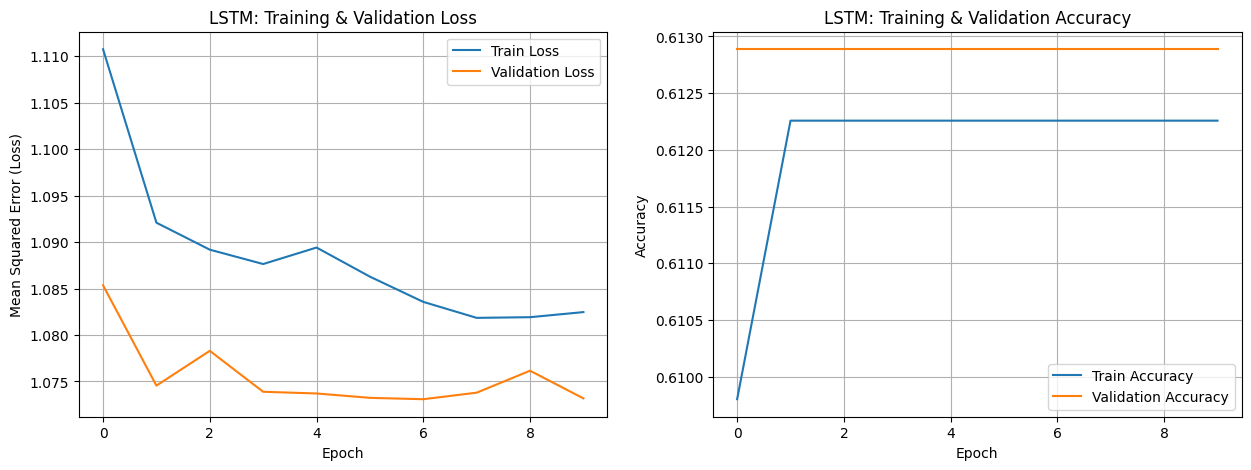

In [37]:
plot_curves(history, "LSTM")

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [40]:

# Get predictions on test set
print("\n" + "="*50)
print("GENERATING PREDICTIONS...")
print("="*50)

test_gen.reset()  # Reset generator to start from beginning
predictions = model.predict(test_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Calculate overall metrics
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)
print("\n" + "="*50)
print("OVERALL METRICS")
print("="*50)
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*50)

# Detailed classification report (per-class metrics)
print("\n" + "="*50)
print("CLASSIFICATION REPORT (Per-Class Metrics)")
print("="*50)
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

import numpy as np

# See which classes the model predicts
unique, counts = np.unique(predicted_classes, return_counts=True)
class_labels = list(test_gen.class_indices.keys())

print("\n" + "="*50)
print("PREDICTION DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique, counts):
    print(f"{class_labels[class_idx]}: {count} predictions ({count/len(predicted_classes)*100:.2f}%)")
print("="*50)

# See true class distribution
unique_true, counts_true = np.unique(true_classes, return_counts=True)
print("\n" + "="*50)
print("TRUE CLASS DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique_true, counts_true):
    print(f"{class_labels[class_idx]}: {count} images ({count/len(true_classes)*100:.2f}%)")
print("="*50)


GENERATING PREDICTIONS...
136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step

OVERALL METRICS
Precision: 0.3758 (37.58%)
Recall:    0.6130 (61.30%)
F1-Score:  0.4660 (46.60%)

CLASSIFICATION REPORT (Per-Class Metrics)
              precision    recall  f1-score   support

    Basophil       0.00      0.00      0.00        89
  Eosinophil       0.00      0.00      0.00       322
  Lymphocyte       0.00      0.00      0.00      1034
    Monocyte       0.00      0.00      0.00       234
  Neutrophil       0.61      1.00      0.76      2660

    accuracy                           0.61      4339
   macro avg       0.12      0.20      0.15      4339
weighted avg       0.38      0.61      0.47      4339


PREDICTION DISTRIBUTION
Neutrophil: 4339 predictions (100.00%)

TRUE CLASS DISTRIBUTION
Basophil: 89 images (2.05%)
Eosinophil: 322 images (7.42%)
Lymphocyte: 1034 images (23.83%)
Monocyte: 234 images (5.39%)
Neutrophil: 2660 images (61.30%)


# CNN

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt

In [19]:
initial_model_cnn = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
initial_model_cnn.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy', 
    metrics=['accuracy'])
initial_model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,476,549 (196.37 MB)

 Trainable params: 51,476,549 (196.37 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history_cnn = initial_model_cnn.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    validation_data=valid_gen
)

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.6588 - loss: 1.2356 - val_accuracy: 0.7536 - val_loss: 0.6909
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 254s 995ms/step - accuracy: 0.8337 - loss: 0.4532 - val_accuracy: 0.8229 - val_loss: 0.5021
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 238s 931ms/step - accuracy: 0.8946 - loss: 0.3010 - val_accuracy: 0.8111 - val_loss: 0.5221
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 232s 908ms/step - accuracy: 0.9130 - loss: 0.2515 - val_accuracy: 0.8451 - val_loss: 0.4660
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 222s 871ms/step - accuracy: 0.9273 - loss: 0.2058 - val_accuracy: 0.8396 - val_loss: 0.4437
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 225s 882ms/step - accuracy: 0.9324 - loss: 0.1887 - val_accuracy: 0.8288 - val_loss: 0.4774
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 231s 905ms/step - accuracy: 0.9391 - loss: 0.1684 - val_accuracy: 0.8475 - val_loss: 0.4229
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 236s 926ms/step - accuracy: 0.9484 - lo

In [22]:
initial_cnn_loss, initial_cnn_accuracy = initial_model_cnn.evaluate(test_gen, verbose=0)
print(f"CNN Test Loss: {initial_cnn_loss:.4f}")
print(f"CNN Test Accuracy: {initial_cnn_accuracy:.4f}")

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


CNN Test Loss: 0.1983
CNN Test Accuracy: 0.9345


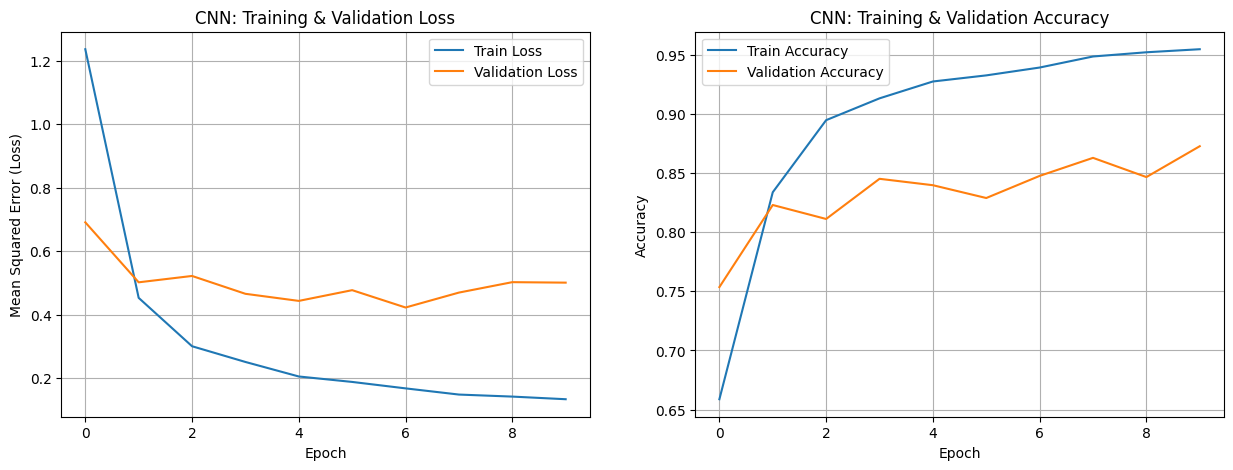

In [26]:
plot_curves(history_cnn, "CNN")

In [27]:

# Get predictions on test set
print("\n" + "="*50)
print("GENERATING PREDICTIONS...")
print("="*50)

test_gen.reset()  # Reset generator to start from beginning
cnn_predictions = initial_model_cnn.predict(test_gen, verbose=1)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)

# Get true labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Calculate overall metrics
cnn_precision = precision_score(true_classes, cnn_predicted_classes, average='weighted', zero_division=0)
cnn_recall = recall_score(true_classes, cnn_predicted_classes, average='weighted', zero_division=0)
cnn_f1 = f1_score(true_classes, cnn_predicted_classes, average='weighted', zero_division=0)
print("\n" + "="*50)
print("OVERALL METRICS")
print("="*50)
print(f"Precision: {cnn_precision:.4f} ({cnn_precision*100:.2f}%)")
print(f"Recall:    {cnn_recall:.4f} ({cnn_recall*100:.2f}%)")
print(f"F1-Score:  {cnn_f1:.4f} ({cnn_f1*100:.2f}%)")
print("="*50)

# Detailed classification report (per-class metrics)
print("\n" + "="*50)
print("CLASSIFICATION REPORT (Per-Class Metrics)")
print("="*50)
print(classification_report(true_classes, cnn_predicted_classes, target_names=class_labels, zero_division=0))

import numpy as np

# See which classes the model predicts
unique, counts = np.unique(cnn_predicted_classes, return_counts=True)
class_labels = list(test_gen.class_indices.keys())

print("\n" + "="*50)
print("PREDICTION DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique, counts):
    print(f"{class_labels[class_idx]}: {count} predictions ({count/len(cnn_predicted_classes)*100:.2f}%)")
print("="*50)

# See true class distribution
unique_true, counts_true = np.unique(true_classes, return_counts=True)
print("\n" + "="*50)
print("TRUE CLASS DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique_true, counts_true):
    print(f"{class_labels[class_idx]}: {count} images ({count/len(true_classes)*100:.2f}%)")
print("="*50)


GENERATING PREDICTIONS...
136/136 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step

OVERALL METRICS
Precision: 0.9451 (94.51%)
Recall:    0.9345 (93.45%)
F1-Score:  0.9372 (93.72%)

CLASSIFICATION REPORT (Per-Class Metrics)
              precision    recall  f1-score   support

    Basophil       1.00      0.89      0.94        89
  Eosinophil       0.65      0.93      0.76       322
  Lymphocyte       0.95      0.98      0.96      1034
    Monocyte       0.86      0.77      0.81       234
  Neutrophil       0.99      0.93      0.96      2660

    accuracy                           0.93      4339
   macro avg       0.89      0.90      0.89      4339
weighted avg       0.95      0.93      0.94      4339


PREDICTION DISTRIBUTION
Basophil: 79 predictions (1.82%)
Eosinophil: 461 predictions (10.62%)
Lymphocyte: 1074 predictions (24.75%)
Monocyte: 209 predictions (4.82%)
Neutrophil: 2516 predictions (57.99%)

TRUE CLASS DISTRIBUTION
Basophil: 89 images (2.05%)
Eosinophil: 322 images (7.42%)
Lymphocyte

# ResNet

# SVM

# Final Comparisons

/var/folders/15/5_06gwdn0rs16jky7k2nfmvr0000gn/T/ipykernel_45740/2665957484.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/15/5_06gwdn0rs16jky7k2nfmvr0000gn/T/ipykernel_45740/2665957484.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/var/folders/15/5_06gwdn0rs16jky7k2nfmvr0000gn/T/ipykernel_45740/2665957484.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


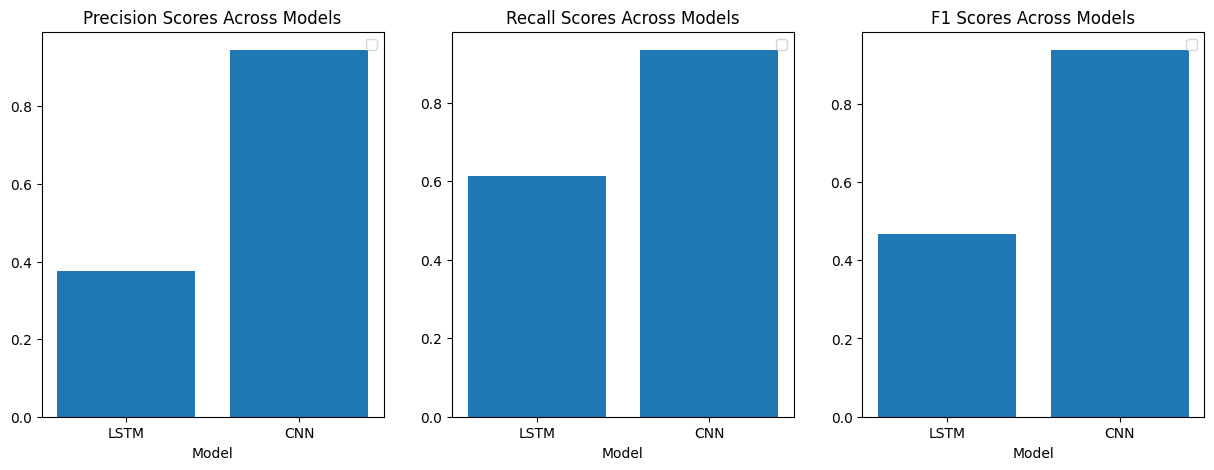

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.bar(["LSTM", "CNN"], [precision, cnn_precision])
ax1.set_title("Precision Scores Across Models")
ax1.set_xlabel("Model")
ax1.legend()

ax2.bar(["LSTM", "CNN"], [recall, cnn_recall])
ax2.set_title("Recall Scores Across Models")
ax2.set_xlabel("Model")
ax2.legend()

ax3.bar(["LSTM", "CNN"], [f1, cnn_f1])
ax3.set_title("F1 Scores Across Models")
ax3.set_xlabel("Model")
ax3.legend()

plt.show()